In [1]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv(
    '../input/twitter-airline-sentiment/Tweets.csv',
    encoding='latin-1')

In [3]:
df= df[['airline_sentiment','text']].copy()
df.columns = ['Sentiment','SentimentText']

In [4]:
df.Sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: Sentiment, dtype: int64

In [5]:
mapper = {'negative':0,
         'neutral':1,
         'positive':2}

In [6]:
df.Sentiment = df.Sentiment.map(mapper)

In [7]:
df.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [8]:
df.shape

(14640, 2)

In [9]:
df.head()

,Sentiment,SentimentText
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials t...
2,1,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...


In [10]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text):
# removendo link,user e caracteres e especiais
# removing links,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    return text

In [12]:
df.SentimentText = df.SentimentText.apply(lambda x: preprocess(x))
df.Sentiment = df.Sentiment.astype('int64')

In [13]:
df.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [14]:
train, valid = train_test_split(df,random_state=56)

In [15]:
labels = keras.utils.to_categorical(train['Sentiment'].astype('int64'))
train_text = np.array(train['SentimentText'].tolist().copy())

In [16]:
labels_valid = keras.utils.to_categorical(valid['Sentiment'].astype('int64'))
valid_text = np.array(valid['SentimentText'].tolist().copy())


In [17]:
vocab_size = 1000
embedding_dim = 16
max_length = 142
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_text)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(valid_text)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [18]:
testing_padded

array([[  3,  83,  44, ...,   0,   0,   0],
       [ 67,  20,   6, ...,   0,   0,   0],
       [  1,  76,   0, ...,   0,   0,   0],
       ...,
       [149, 569, 249, ...,   0,   0,   0],
       [ 61,  41,   6, ...,   0,   0,   0],
       [  1,   1,   4, ...,   0,   0,   0]], dtype=int32)

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[0]))
print()
print(train_text[0])

how much is it to check <OOV> <OOV> on a flight they might be <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?

how much is it to check golf clubs on a flight they might be oversized


In [20]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 softmax layer [0, 1 or 2(negative, neutral or positive)]
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 142, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 16,323
Trainable params: 16,323
Non-trainable params: 0
_________________________________________________________________


In [21]:
#just adding some early stopping to prevent overfitting
monitor = keras.callbacks.EarlyStopping(patience=5,min_delta=0.01,monitor='val_accuracy',restore_best_weights=True)

In [22]:
num_epochs = 30
history = model.fit(padded, labels, epochs=num_epochs, validation_data=(testing_padded, labels_valid),
         callbacks=[monitor]);

Epoch 1/30
344/344 [==============================] - 2s 4ms/step - loss: 0.9750 - accuracy: 0.6176 - val_loss: 0.9104 - val_accuracy: 0.6199
Epoch 2/30
344/344 [==============================] - 1s 2ms/step - loss: 0.8864 - accuracy: 0.6336 - val_loss: 0.8524 - val_accuracy: 0.6199
Epoch 3/30
344/344 [==============================] - 1s 2ms/step - loss: 0.8118 - accuracy: 0.6389 - val_loss: 0.7597 - val_accuracy: 0.6199
Epoch 4/30
344/344 [==============================] - 1s 2ms/step - loss: 0.7403 - accuracy: 0.6364 - val_loss: 0.7104 - val_accuracy: 0.6587
Epoch 5/30
344/344 [==============================] - 1s 2ms/step - loss: 0.7002 - accuracy: 0.6716 - val_loss: 0.6779 - val_accuracy: 0.6743
Epoch 6/30
344/344 [==============================] - 1s 2ms/step - loss: 0.6672 - accuracy: 0.6886 - val_loss: 0.6486 - val_accuracy: 0.7421
Epoch 7/30
344/344 [==============================] - 1s 2ms/step - loss: 0.6312 - accuracy: 0.7348 - val_loss: 0.6318 - val_accuracy: 0.7560
Epoch 

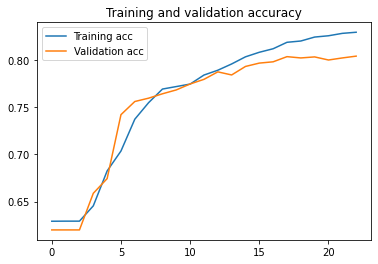

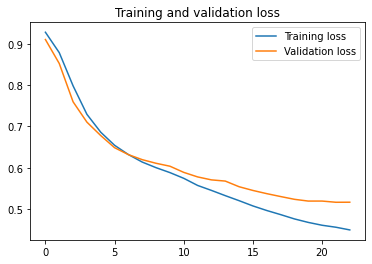

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(max(history.epoch)+1)
 
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [24]:
#Running the prediction on the test split
predictions = np.argmax(model.predict(testing_padded),-1)

In [25]:
# We can inverse our dict to easy apply map function to transform the numbers into classes again
mapper_inverse = {v:k for v,k in zip(range(3),mapper)}
df_comp = pd.DataFrame()
df_comp['Pred'] = pd.Series(predictions).map(mapper_inverse)
df_comp['True'] = valid['Sentiment'].map(mapper_inverse).values
df_comp

,Pred,True
0,negative,negative
1,negative,neutral
2,neutral,neutral
3,negative,negative
4,positive,neutral
...,...,...
3655,neutral,neutral
3656,neutral,neutral
3657,negative,negative
3658,negative,negative


In [26]:
#Let's see our accuracy!
accuracy_score(predictions,valid['Sentiment'].values)

0.803551912568306